In [26]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O 

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/network-intrusion-detection/Train_data.csv
/kaggle/input/network-intrusion-detection/Test_data.csv


# Data Preprocessing

In [27]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Load dataset
train = pd.read_csv("/kaggle/input/network-intrusion-detection/Train_data.csv")

# Label Encoding
label_encoder = LabelEncoder()
for col in train.select_dtypes(include='object').columns:
    train[col] = label_encoder.fit_transform(train[col])

# Split Features & Labels
X = train.drop(columns=['class'])
y = train['class']

# Save feature names for later use in SHAP/LIME
feature_names = X.columns.tolist()

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)
#X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.80, random_state=42)

# Build  and Train the Machine Learning (ML) Models

**Tree-based Models:** Random Forest, Decision Tree, Extreme Gradient Boosting (XGBoost)

**Linear or Kernel-based Models:** Support Vector Machine (SVM), Logistic Regression, K-Nearest Neighbors (KNN)

In [28]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
# Metrics & Evaluation
from sklearn.metrics import (
    accuracy_score, confusion_matrix, precision_score, recall_score, 
    f1_score, roc_auc_score, classification_report, precision_recall_curve,
    r2_score, mean_squared_error
)

def train_model(model, X_train, X_test, y_train, y_test, model_name):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print(f"\n{'='*20} {model_name} {'='*20}")
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print("Precision: ", precision_score(y_test, y_pred))
    print("Recall: ", recall_score(y_test, y_pred))
    print("F1-score: ", f1_score(y_test, y_pred))
    print("Classification Report:\n", classification_report(y_test, y_pred))
    print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
    
    cm = confusion_matrix(y_test, y_pred)
    tn, fp, fn, tp = cm.ravel()
    print("\nConfusion Matrix Parameters:")
    print(f"True Negatives (TN): {tn}")
    print(f"False Positives (FP): {fp}")
    print(f"False Negatives (FN): {fn}")
    print(f"True Positives (TP): {tp}")
    return model

# Train models
rfc = train_model(RandomForestClassifier(n_estimators=100, random_state=42), X_train, X_test, y_train, y_test, "Random Forest")
dtc = train_model(DecisionTreeClassifier(random_state=42), X_train, X_test, y_train, y_test, "Decision Tree")
xgb = train_model(XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42), X_train, X_test, y_train, y_test, "XGBoost")

svm = train_model(SVC(kernel='rbf', probability=True, random_state=42), X_train, X_test, y_train, y_test, "Support Vector Machine")
lr  = train_model(LogisticRegression(max_iter=1000, random_state=42), X_train, X_test, y_train, y_test, "Logistic Regression")
knn = train_model(KNeighborsClassifier(n_neighbors=5), X_train, X_test, y_train, y_test, "K-Nearest Neighbors")


==================== Random Forest ====================
Accuracy: 0.9978170271879341
Precision:  0.9973851326111318
Recall:  0.9985041136873598
F1-score:  0.9979443094748646
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      2365
           1       1.00      1.00      1.00      2674

    accuracy                           1.00      5039
   macro avg       1.00      1.00      1.00      5039
weighted avg       1.00      1.00      1.00      5039

Confusion Matrix:
 [[2358    7]
 [   4 2670]]

Confusion Matrix Parameters:
True Negatives (TN): 2358
False Positives (FP): 7
False Negatives (FN): 4
True Positives (TP): 2670

==================== Decision Tree ====================
Accuracy: 0.9958325064496923
Precision:  0.9966304754773493
Recall:  0.9955123410620793
F1-score:  0.9960710944808232
Classification Report:
               precision    recall  f1-score   support

           0       0.99      1.00      1.00 

# Tree-based Models

**SHAP Summary Plot - Random Forest, Decision Tree, Extreme Gradient Boosting (XGBoost)**

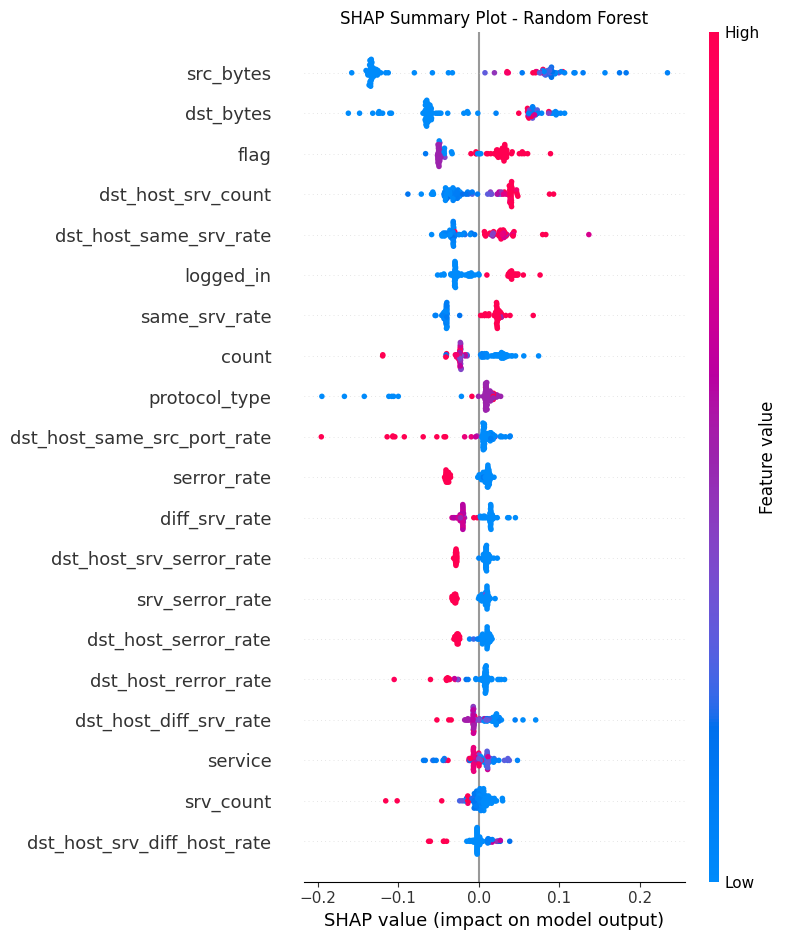

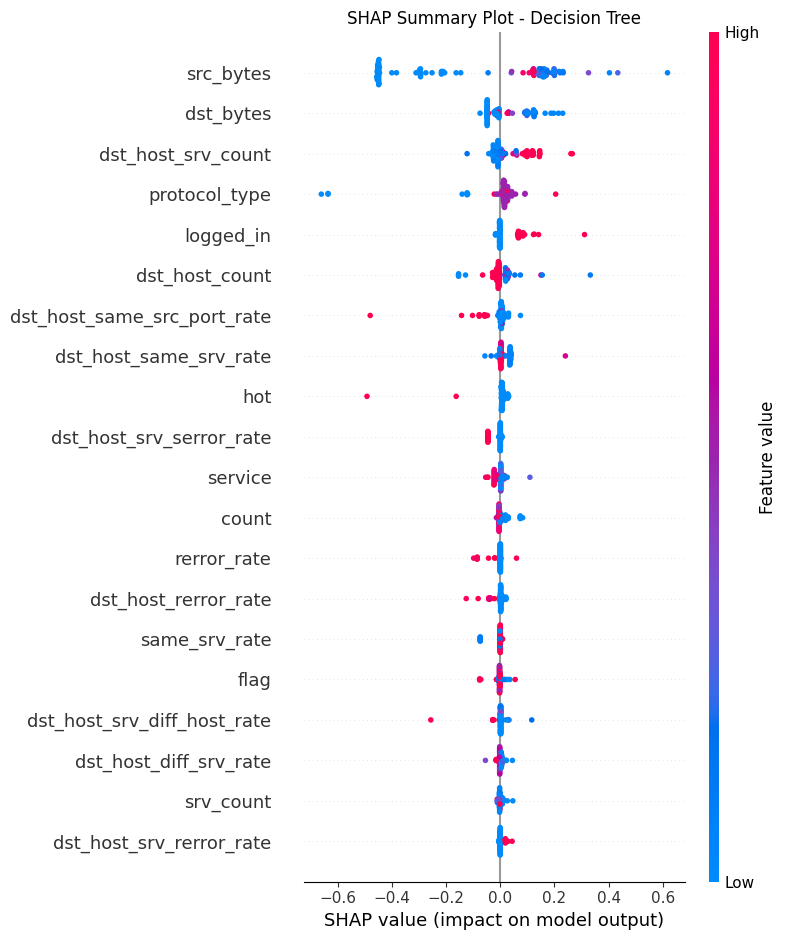

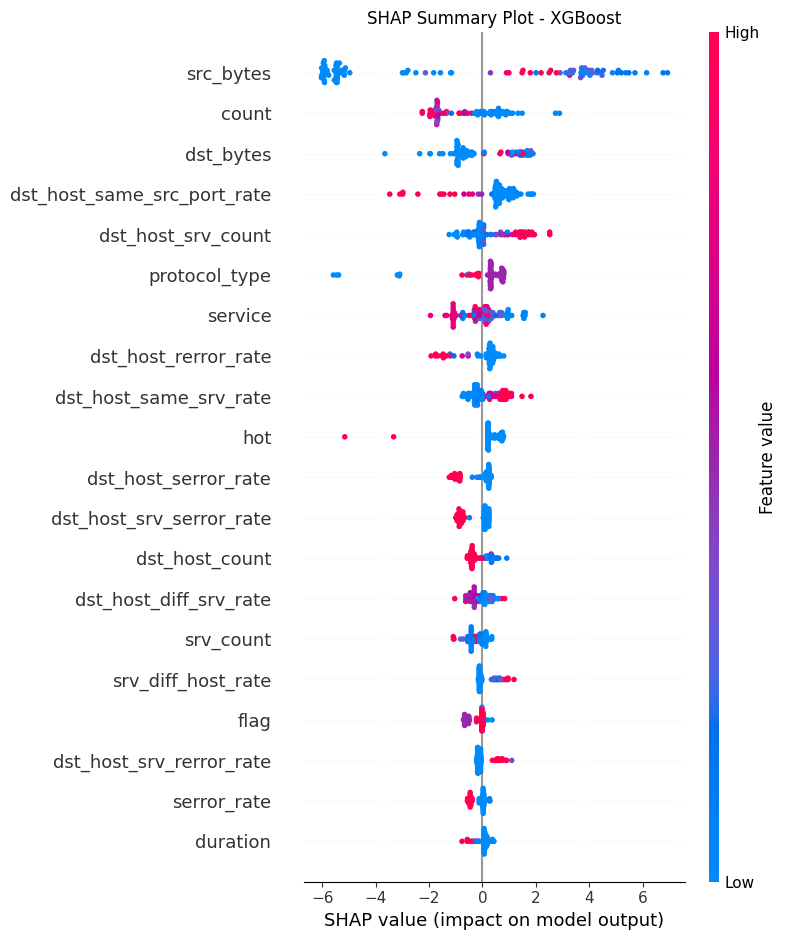

In [29]:
import shap
import lime
import lime.lime_tabular
import matplotlib.pyplot as plt
import numpy as np

# Sample 100 points for explanation
X_sample = X_test.sample(n=100, random_state=42)
y_sample = y_test.loc[X_sample.index]

# SHAP Explainers (Tree-based only)
explainer_rfc = shap.TreeExplainer(rfc)
explainer_dtc = shap.TreeExplainer(dtc)
explainer_xgb = shap.TreeExplainer(xgb)

# Compute SHAP values
shap_values_rfc = explainer_rfc.shap_values(X_sample)
shap_values_dtc = explainer_dtc.shap_values(X_sample)
shap_values_xgb = explainer_xgb.shap_values(X_sample)

# SHAP Summary Plots
shap.summary_plot(shap_values_rfc[1], X_sample, feature_names=feature_names, show=False)
plt.title("SHAP Summary Plot - Random Forest")
plt.tight_layout()
plt.show()

shap.summary_plot(shap_values_dtc[1], X_sample, feature_names=feature_names, show=False)
plt.title("SHAP Summary Plot - Decision Tree")
plt.tight_layout()
plt.show()

shap.summary_plot(shap_values_xgb, X_sample, feature_names=feature_names, show=False)
plt.title("SHAP Summary Plot - XGBoost")
plt.tight_layout()
plt.show()

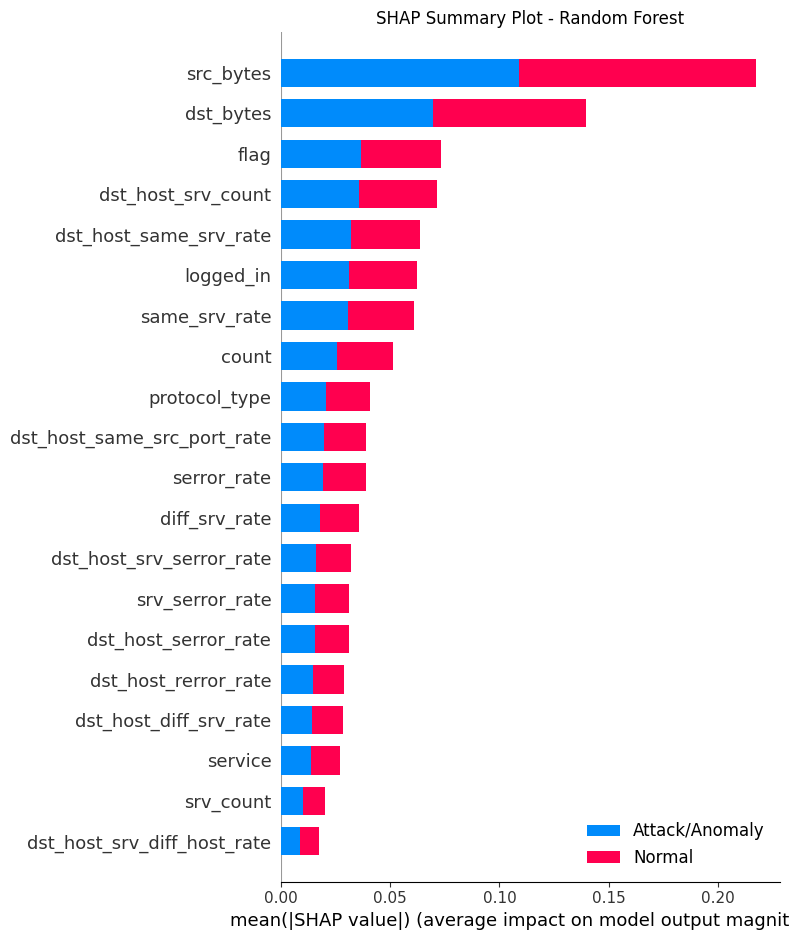

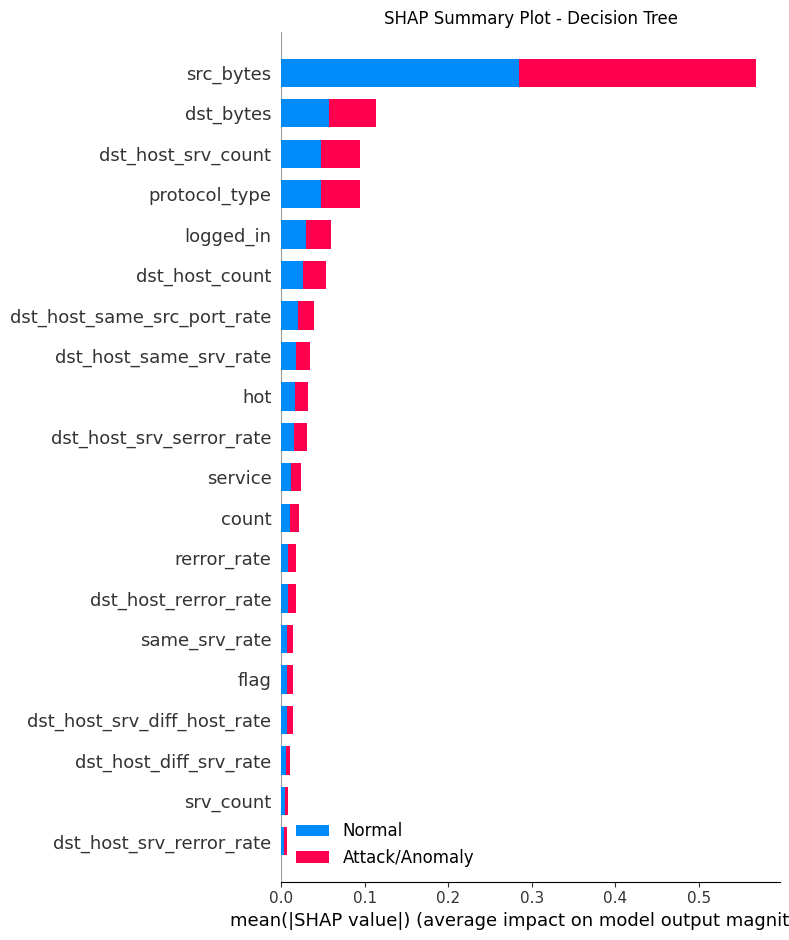

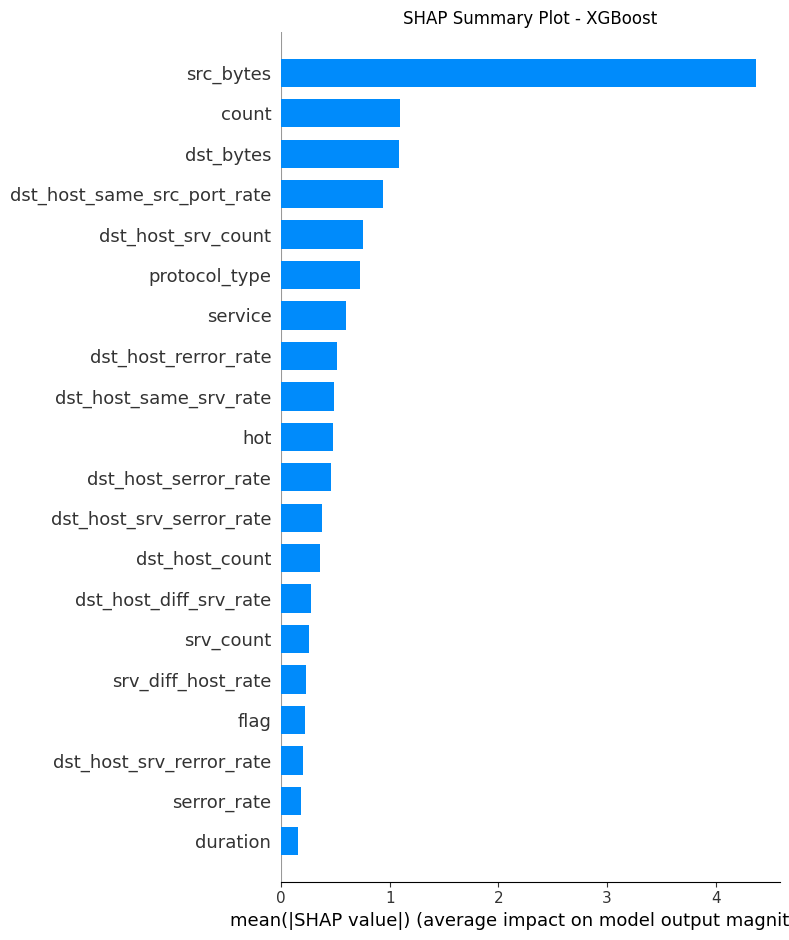

In [30]:
# SHAP Bar plot for Random Forest, Decision Tree, and XGBoost
shap.summary_plot(shap_values_rfc, X_sample, feature_names=feature_names, class_names=['Normal', 'Attack/Anomaly'], show=False)
plt.title("SHAP Summary Plot - Random Forest")
plt.tight_layout()
plt.show()

shap.summary_plot(shap_values_dtc, X_sample, feature_names=feature_names, class_names=['Normal', 'Attack/Anomaly'],show=False)
plt.title("SHAP Summary Plot - Decision Tree")
plt.tight_layout()
plt.show()

shap.summary_plot(shap_values_xgb, X_sample, plot_type="bar", feature_names=feature_names, class_names=['Normal', 'Attack/Anomaly'],show=False)
plt.title("SHAP Summary Plot - XGBoost")
plt.tight_layout()
plt.show()
# Force plot for a single prediction (e.g., first test sample)
shap.initjs()
shap.force_plot(explainer_xgb.expected_value, shap_values_xgb, X_sample)

**LIME explainer- Random Forest, Decision Tree, Extreme Gradient Boosting (XGBoost)**

In [31]:
from lime.lime_tabular import LimeTabularExplainer

# Use only first 100 training samples for LIME explainer
lime_explainer = LimeTabularExplainer(
    training_data=X_train.values,
    feature_names=feature_names,
    class_names=["Attack/Anomaly", "Normal"],
    discretize_continuous=True,
    mode='classification'
)

# Explain first instance
idx = 0

> **Random Forest**

LIME - Random Forest


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


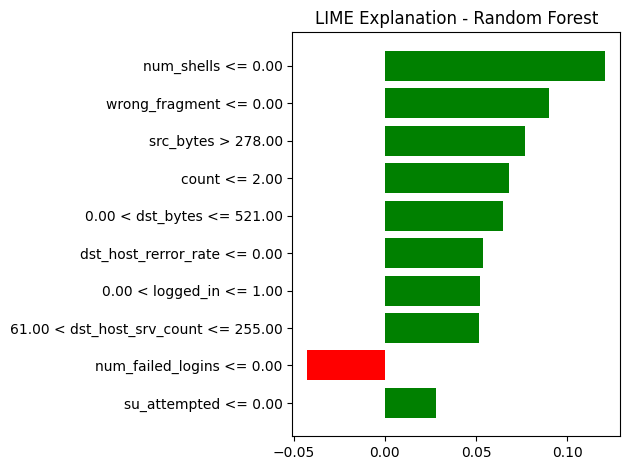

In [32]:
exp_rf = lime_explainer.explain_instance(X_sample.iloc[idx].values, rfc.predict_proba, num_features=10)
print("LIME - Random Forest")
exp_rf.show_in_notebook(show_table=True)
fig_rf = exp_rf.as_pyplot_figure()
plt.title("LIME Explanation - Random Forest")
plt.tight_layout()
plt.show()

> **Decision Tree**

LIME - Decision Tree


X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names


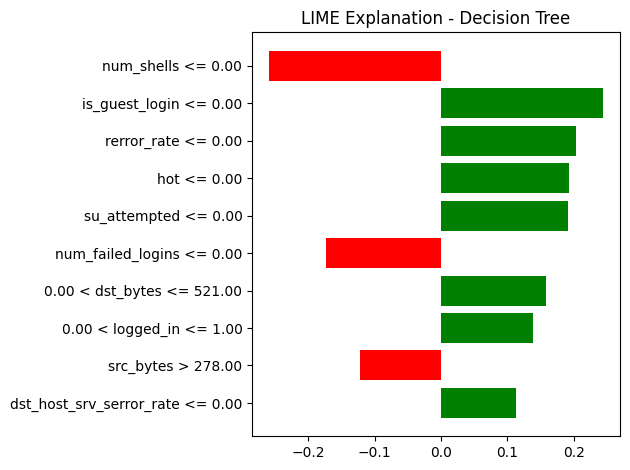

In [33]:
exp_dt = lime_explainer.explain_instance(X_sample.iloc[idx].values, dtc.predict_proba, num_features=10)
print("LIME - Decision Tree")
exp_dt.show_in_notebook(show_table=True)
fig_dt = exp_dt.as_pyplot_figure()
plt.title("LIME Explanation - Decision Tree")
plt.tight_layout()
plt.show()

> **Extreme Gradient Boosting (XGBoost)**

LIME - XGBoost


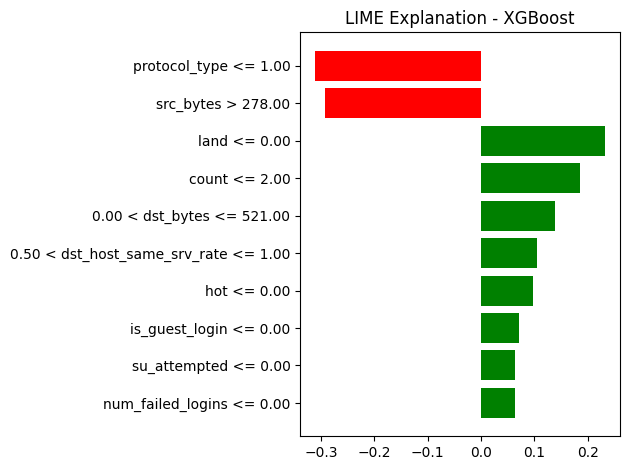

In [34]:
exp_xgb = lime_explainer.explain_instance(X_sample.iloc[idx].values, xgb.predict_proba, num_features=10)
print("LIME - XGBoost")
exp_xgb.show_in_notebook(show_table=True)
fig_xgb = exp_xgb.as_pyplot_figure()
plt.title("LIME Explanation - XGBoost")
plt.tight_layout()
plt.show()

# Linear or Kernel-based Models

**SHAP Summary Plot - Support Vector Machine (SVM), Logistic Regression, K-Nearest Neighbors (KNN)**

In [35]:
import shap
import time

# Sampling 100 background samples and 10 test samples
X_background = shap.utils.sample(X_train, 100, random_state=42)
X_sample = X_test.sample(10, random_state=42)
#X_sample = X_test.groupby(y_test).apply(lambda x: x.sample(5, random_state=42)).reset_index(drop=True)

> **Logistic Regression**

Explaining Logistic Regression with SHAP...


  0%|          | 0/10 [00:00<?, ?it/s]

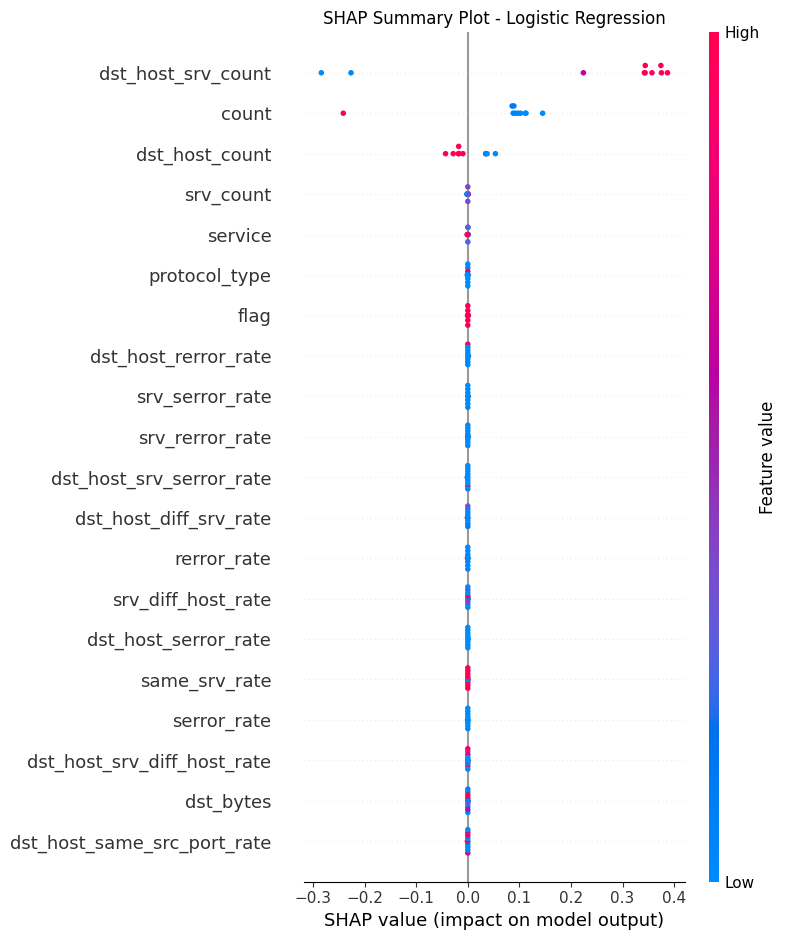

In [36]:
# SHAP KernelExplainer for Logistic Regression
print("Explaining Logistic Regression with SHAP...")
explainer_lr = shap.KernelExplainer(lr.predict_proba, X_background)
shap_values_lr = explainer_lr.shap_values(X_sample)
shap.summary_plot(shap_values_lr[1], X_sample, feature_names=feature_names, show=False)
plt.title("SHAP Summary Plot - Logistic Regression")
plt.tight_layout()
plt.show()

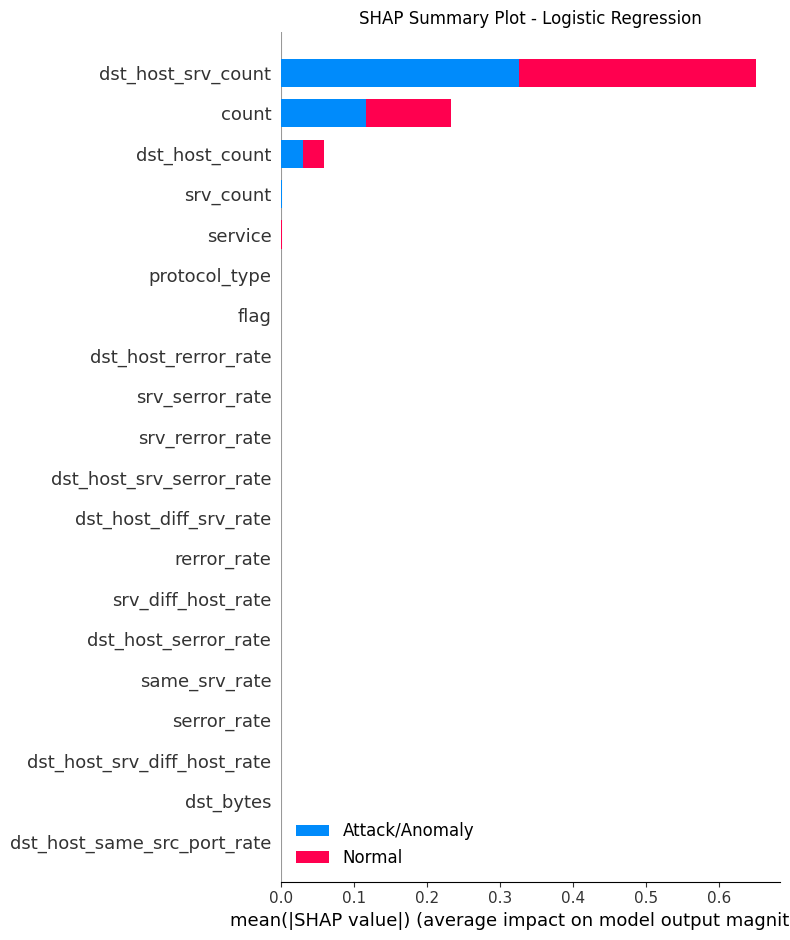

In [37]:
# SHAP Bar plot for Logistic Regression
shap.summary_plot(shap_values_lr, X_sample, feature_names=feature_names, class_names=['Normal', 'Attack/Anomaly'],show=False)
plt.title("SHAP Summary Plot - Logistic Regression")
plt.tight_layout()
plt.show()

> **K-Nearest Neighbors (KNN)**

Explaining KNN with SHAP...


  0%|          | 0/10 [00:00<?, ?it/s]

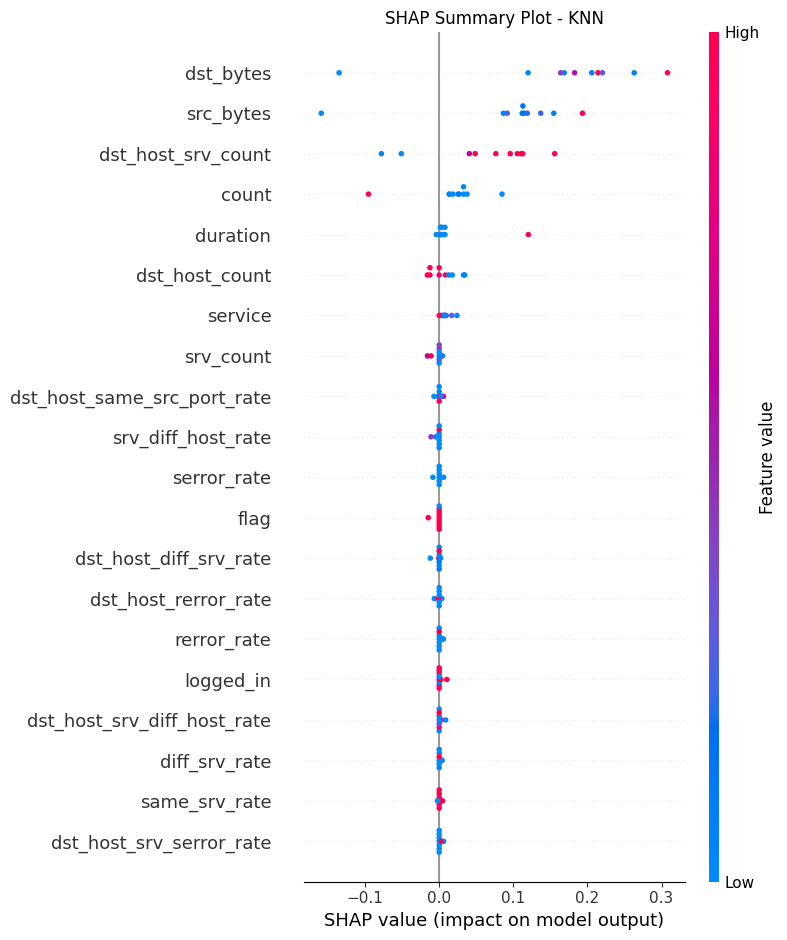

In [38]:
# SHAP KernelExplainer for KNN
print("Explaining KNN with SHAP...")
explainer_knn = shap.KernelExplainer(knn.predict_proba, X_background)
shap_values_knn = explainer_knn.shap_values(X_sample)
shap.summary_plot(shap_values_knn[1], X_sample, feature_names=feature_names, show=False)
plt.title("SHAP Summary Plot - KNN")
plt.tight_layout()
plt.show()

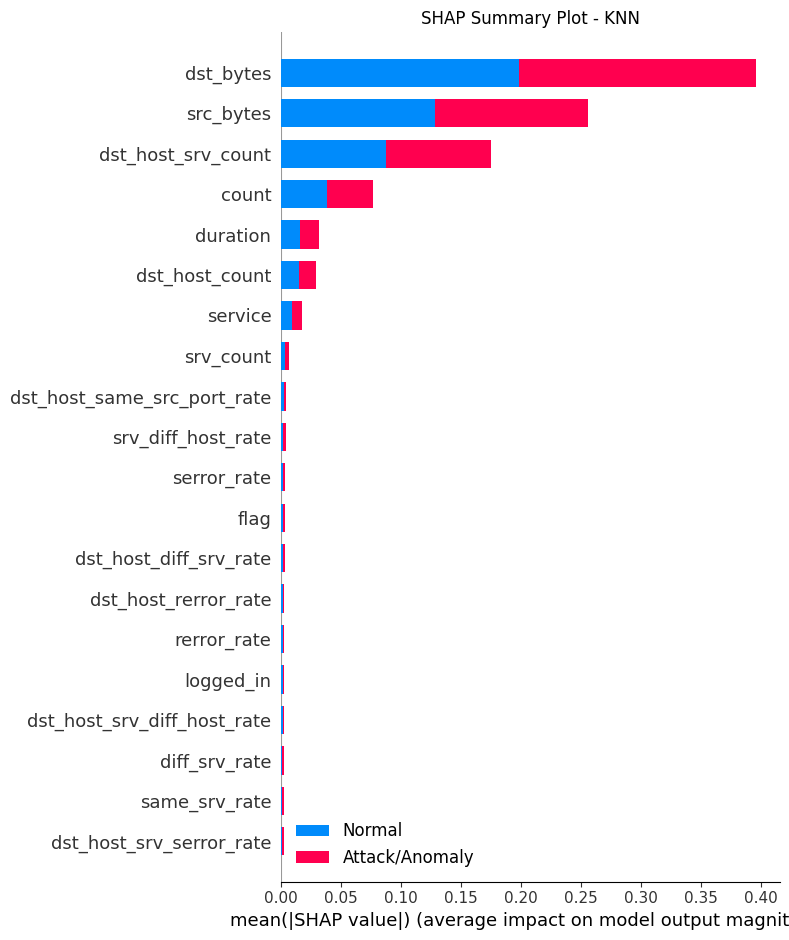

In [39]:
# SHAP Bar plot for KNN
shap.summary_plot(shap_values_knn, X_sample, feature_names=feature_names, class_names=['Normal', 'Attack/Anomaly'],show=False)
plt.title("SHAP Summary Plot - KNN")
plt.tight_layout()
plt.show()

# Build and Train the Deep Learning (DL) Models

**Sequence or Spatial Neural Network-Based Models:** CNN (Convolutional Neural Network) & RNN (Recurrent Neural Network)

**Fully Connected or Feedforward Neural Network-Based Models:** ANN (Artificial Neural Network)	& MLP (Multilayer Perceptron)

In [40]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, SimpleRNN
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Convert labels to categorical (binary classification: 0 = Anomaly, 1 = Normal)
y_train_cat = to_categorical(y_train, num_classes=2)
y_test_cat = to_categorical(y_test, num_classes=2)

# Reshape for CNN/RNN
X_train_reshaped = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test_reshaped = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

> **Convolutional Neural Networks (CNNs)**

In [41]:
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten

model_cnn = Sequential([
    Conv1D(32, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], 1)),
    MaxPooling1D(pool_size=2),
    Flatten(),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(2, activation='softmax')
])

model_cnn.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

history_cnn = model_cnn.fit(X_train_reshaped, y_train_cat, validation_split=0.2, epochs=10, batch_size=32)

Epoch 1/10


Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.


504/504 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.9307 - loss: 0.2058 - val_accuracy: 0.9660 - val_loss: 0.0922
Epoch 2/10
504/504 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9695 - loss: 0.0808 - val_accuracy: 0.9789 - val_loss: 0.0663
Epoch 3/10
504/504 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9785 - loss: 0.0716 - val_accuracy: 0.9824 - val_loss: 0.0542
Epoch 4/10
504/504 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9827 - loss: 0.0621 - val_accuracy: 0.9849 - val_loss: 0.0475
Epoch 5/10
504/504 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9862 - loss: 0.0391 - val_accuracy: 0.9846 - val_loss: 0.0484
Epoch 6/10
504/504 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9885 - loss: 0.0319 - val_accuracy: 0.9841 - val_loss: 0.0567
Epoch 7/10
504/504 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9874 - loss: 0.0457 - val_accuracy: 0.9864 - val_loss: 0.0477
Epoch 8/10
504/504 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9883 - loss: 0.0363 - val_accuracy: 0.9866 - val_

> **Recurrent Neural Networks (RNNs)**

In [42]:
from tensorflow.keras.layers import LSTM

model_rnn = Sequential([
    LSTM(64, input_shape=(X_train.shape[1], 1)),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dense(2, activation='softmax')
])

model_rnn.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

history_rnn = model_rnn.fit(X_train_reshaped, y_train_cat, validation_split=0.2, epochs=10, batch_size=32)

Epoch 1/10


Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.


504/504 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.9019 - loss: 0.3330 - val_accuracy: 0.9516 - val_loss: 0.1307
Epoch 2/10
504/504 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.9459 - loss: 0.1308 - val_accuracy: 0.9663 - val_loss: 0.0895
Epoch 3/10
504/504 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.9632 - loss: 0.0905 - val_accuracy: 0.9705 - val_loss: 0.0753
Epoch 4/10
504/504 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.9690 - loss: 0.0787 - val_accuracy: 0.9749 - val_loss: 0.0657
Epoch 5/10
504/504 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.9725 - loss: 0.0721 - val_accuracy: 0.9730 - val_loss: 0.0693
Epoch 6/10
504/504 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.9750 - loss: 0.0663 - val_accuracy: 0.9762 - val_loss: 0.0574
Epoch 7/10
504/504 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.9744 - loss: 0.0635 - val_accuracy: 0.9784 - val_loss: 0.0600
Epoch 8/10
504/504 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.9812 - loss: 0.0551 - val_accuracy: 0.9779 - val_

> **Artificial Neural Networks (ANNs)**

In [43]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

model_ann = Sequential([
    Dense(64, input_dim=X_train.shape[1], activation='relu'),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dense(2, activation='softmax')
])

model_ann.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

history_ann = model_ann.fit(X_train, y_train_cat, validation_split=0.2, epochs=10, batch_size=32)

Epoch 1/10


Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.


504/504 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.9312 - loss: 0.1989 - val_accuracy: 0.9680 - val_loss: 0.0739
Epoch 2/10
504/504 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9752 - loss: 0.0718 - val_accuracy: 0.9794 - val_loss: 0.0545
Epoch 3/10
504/504 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9803 - loss: 0.0524 - val_accuracy: 0.9809 - val_loss: 0.0492
Epoch 4/10
504/504 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9850 - loss: 0.0465 - val_accuracy: 0.9831 - val_loss: 0.0455
Epoch 5/10
504/504 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9876 - loss: 0.0414 - val_accuracy: 0.9856 - val_loss: 0.0371
Epoch 6/10
504/504 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9871 - loss: 0.0360 - val_accuracy: 0.9844 - val_loss: 0.0449
Epoch 7/10
504/504 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9874 - loss: 0.0447 - val_accuracy: 0.9856 - val_loss: 0.0376
Epoch 8/10
504/504 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9889 - loss: 0.0323 - val_accuracy: 0.9881 - val_

> **Multilayer Perceptron (MLP)**

In [44]:
model_mlp = Sequential([
    Dense(128, input_dim=X_train.shape[1], activation='relu'),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(2, activation='softmax')
])

model_mlp.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

history_mlp = model_mlp.fit(X_train, y_train_cat, validation_split=0.2, epochs=10, batch_size=32)

Epoch 1/10
504/504 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.9480 - loss: 0.1715 - val_accuracy: 0.9735 - val_loss: 0.0682
Epoch 2/10
504/504 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9782 - loss: 0.0610 - val_accuracy: 0.9849 - val_loss: 0.0508
Epoch 3/10
504/504 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9848 - loss: 0.0451 - val_accuracy: 0.9834 - val_loss: 0.0492
Epoch 4/10
504/504 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9870 - loss: 0.0359 - val_accuracy: 0.9831 - val_loss: 0.0454
Epoch 5/10
504/504 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9890 - loss: 0.0318 - val_accuracy: 0.9854 - val_loss: 0.0474
Epoch 6/10
504/504 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9882 - loss: 0.0354 - val_accuracy: 0.9856 - val_loss: 0.0335
Epoch 7/10
504/504 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9894 - loss: 0.0255 - val_accuracy: 0.9876 - val_loss: 0.0319
Epoch 8/10
504/504 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9903 - loss: 0.0280 - val_accuracy: 0.

**Evaluation of Deep Learning (DL) Models**

In [45]:
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    classification_report, confusion_matrix, roc_auc_score, roc_curve
)
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def evaluate_dl_model(model, X_test, y_test, model_name, reshaped=False):
    """
    Evaluates a trained DL model and prints metrics + visualizations.

    Parameters:
    - model: Trained Keras model
    - X_test: Test data (reshaped or not)
    - y_test: Ground truth (one-hot encoded)
    - model_name: Model label (str)
    - reshaped: Whether X_test is 3D (for CNN/RNN)
    """

    print(f"\n{'='*20} {model_name.upper()} {'='*20}")

    # Prediction Probabilities & Labels
    y_pred_proba = model.predict(X_test)
    y_pred = np.argmax(y_pred_proba, axis=1)
    y_true = np.argmax(y_test, axis=1)

    # Classification Metrics
    print("Accuracy:", accuracy_score(y_true, y_pred))
    print("Precision: ", precision_score(y_true, y_pred))
    print("Recall: ", recall_score(y_true, y_pred))
    print("F1-score: ", f1_score(y_true, y_pred))
    auc = roc_auc_score(y_true, y_pred_proba[:, 1])
    print("ROC AUC: ", auc)
    print("Classification Report:\n", classification_report(y_true, y_pred))
    
    # Confusion Matrix
    print("Confusion Matrix:\n", confusion_matrix(y_true, y_pred))

    cm = confusion_matrix(y_true, y_pred)
    tn, fp, fn, tp = cm.ravel()
    print("\nConfusion Matrix Parameters:")
    print(f"True Negatives (TN): {tn}")
    print(f"False Positives (FP): {fp}")
    print(f"False Negatives (FN): {fn}")
    print(f"True Positives (TP): {tp}")
    
# CNN
evaluate_dl_model(model_cnn, X_test_reshaped, y_test_cat, model_name="CNN", reshaped=True)

# RNN
evaluate_dl_model(model_rnn, X_test_reshaped, y_test_cat, model_name="RNN", reshaped=True)

# ANN
evaluate_dl_model(model_ann, X_test, y_test_cat, model_name="ANN")

# MLP
evaluate_dl_model(model_mlp, X_test, y_test_cat, model_name="MLP")



==================== CNN ====================
158/158 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Accuracy: 0.9882913276443739
Precision:  0.9932101093926821
Recall:  0.9846671652954375
F1-score:  0.9889201877934272
ROC AUC:  0.9984803154960223
Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.99      0.99      2365
           1       0.99      0.98      0.99      2674

    accuracy                           0.99      5039
   macro avg       0.99      0.99      0.99      5039
weighted avg       0.99      0.99      0.99      5039

Confusion Matrix:
 [[2347   18]
 [  41 2633]]

Confusion Matrix Parameters:
True Negatives (TN): 2347
False Positives (FP): 18
False Negatives (FN): 41
True Positives (TP): 2633

==================== RNN ====================
158/158 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Accuracy: 0.979162532248462
Precision:  0.9874762808349146
Recall:  0.9730740463724757
F1-score:  0.9802222640798645
ROC AUC:  0.9985534494727238
Cl

Unified head:
   proto   service  duration  orig_bytes  resp_bytes conn_state  orig_pkts  \
0   tcp  ftp_data       0.0       491.0         0.0         SF          1   
1   udp     other       0.0       146.0         0.0         SF          1   
2   tcp   private       0.0         0.0         0.0         S0          1   
3   tcp      http       0.0       232.0      8153.0         SF          1   
4   tcp      http       0.0       199.0       420.0         SF          1   

   orig_ip_bytes  resp_pkts  resp_ip_bytes    class  
0          491.0          0              0   normal  
1          146.0          0              0   normal  
2            0.0          0              0  anomaly  
3          232.0          0              0   normal  
4          199.0          0              0   normal   

Dtypes:
 proto             object
service           object
duration         float64
orig_bytes       float64
resp_bytes       float64
conn_state        object
orig_pkts          int64
orig_ip_byte

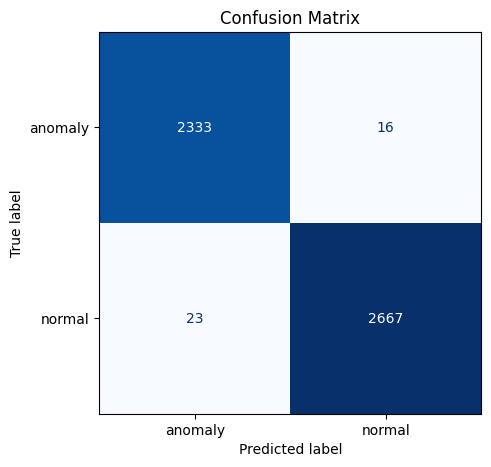

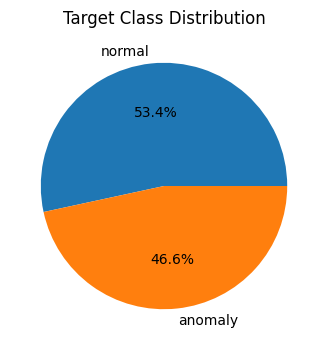

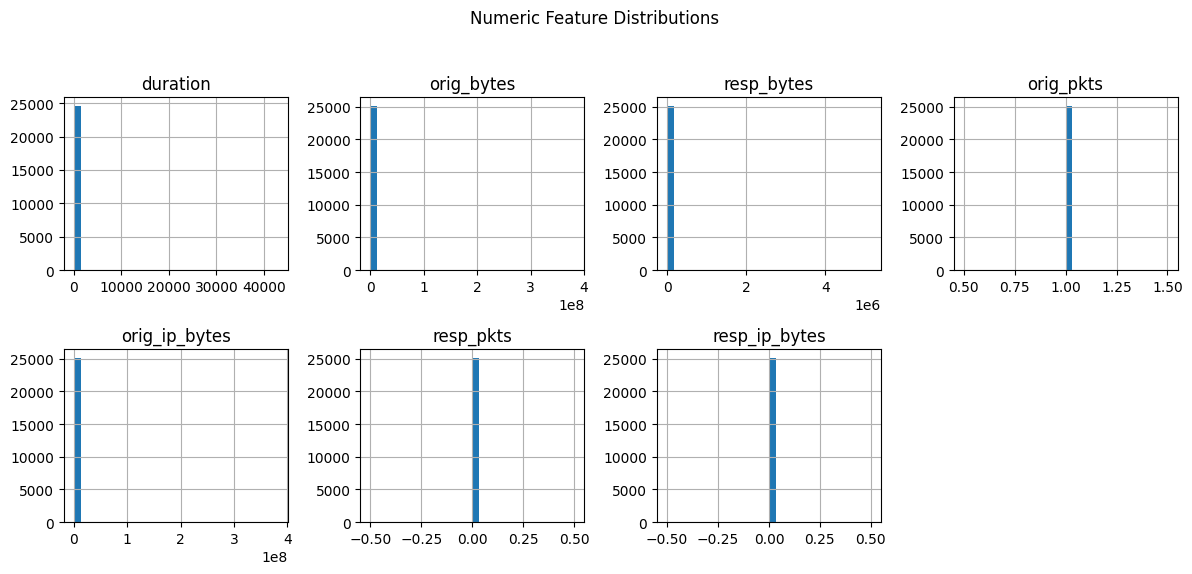

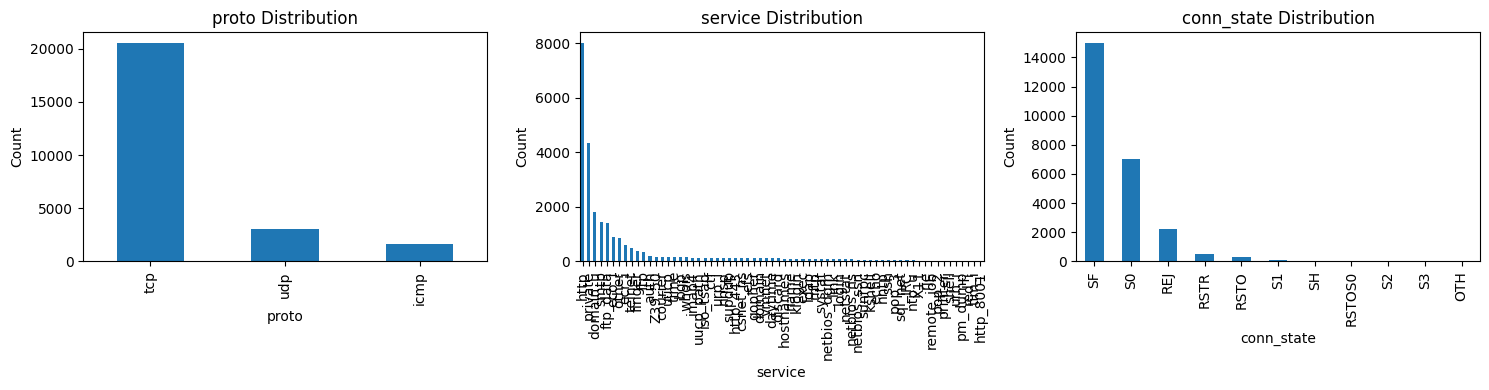

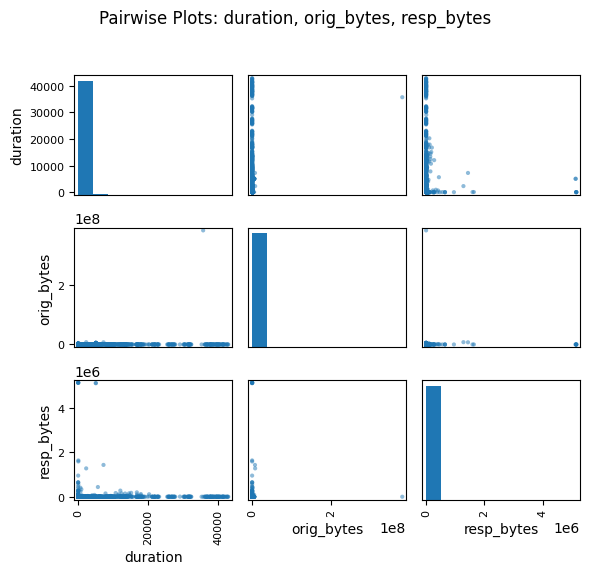

In [46]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from xgboost import XGBClassifier
import joblib
import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix

# 0) Load the raw KDD-style CSV
train = pd.read_csv('/kaggle/input/network-intrusion-detection/Train_data.csv')

# 1) Build unified-feature DataFrame from 'train'
df_packet = pd.DataFrame({
    'proto'         : train['protocol_type'],
    'service'       : train['service'],
    'duration'      : train['duration'].astype(float),
    'orig_bytes'    : train['src_bytes'].astype(float),
    'resp_bytes'    : train['dst_bytes'].astype(float),
    'conn_state'    : train['flag'],
    'orig_pkts'     : 1,
    'orig_ip_bytes' : train['src_bytes'].astype(float),
    'resp_pkts'     : 0,
    'resp_ip_bytes' : 0,
    'class'         : train['class']  # strings 'normal'/'anomaly'
})

# 2) Quick sanity checks
print("Unified head:\n", df_packet.head(), "\n")
print("Dtypes:\n", df_packet.dtypes, "\n")
print("Target distribution:\n", df_packet['class'].value_counts(), "\n")

# 3) Slice features & target
packet_features = [
    'proto','service','duration','orig_bytes','resp_bytes',
    'conn_state','orig_pkts','orig_ip_bytes','resp_pkts','resp_ip_bytes'
]
target_col = 'class'
df_packet = df_packet.dropna(subset=packet_features + [target_col])
X = df_packet[packet_features]
y = df_packet[target_col]

# 4) Encode target labels to integers
target_encoder = LabelEncoder().fit(y)
y_enc = target_encoder.transform(y)
joblib.dump(target_encoder, "encoder_target.pkl")
print("encoder_target.pkl saved; classes =", target_encoder.classes_)

# 5) Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y_enc, test_size=0.2, random_state=42, stratify=y_enc
)

# 6) Build preprocessing & pipeline
categorical_cols = ['proto','service','conn_state']
numeric_cols = [c for c in packet_features if c not in categorical_cols]

preprocessor = ColumnTransformer([
    ('ord', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1), categorical_cols),
    ('scale', StandardScaler(), numeric_cols)
])

pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42))
])

# 7) Fit & save the pipeline
pipeline.fit(X_train, y_train)
joblib.dump(pipeline, "model_3_pipeline.pkl")
print("model_3_pipeline.pkl saved.")

# 8) Sanity check: accuracy
y_pred = pipeline.predict(X_test)
acc = accuracy_score(y_test, y_pred)
print("Model 3 test accuracy:", acc)
print("Decoded prediction example:", target_encoder.inverse_transform(y_pred[:5]))

# 9) Confusion matrix for clarity
cm = confusion_matrix(y_test, y_pred)
labels = target_encoder.classes_
fig, ax = plt.subplots(figsize=(5,5))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(ax=ax, cmap='Blues', colorbar=False)
ax.set_title('Confusion Matrix')
plt.tight_layout()
plt.show()

# --- Visualization Section ---
# 10) Visualize target distribution
class_counts = df_packet['class'].value_counts()
plt.figure(figsize=(6,4))
class_counts.plot.pie(autopct='%1.1f%%')
plt.title('Target Class Distribution')
plt.ylabel('')
plt.show()

# 11) Histograms of numeric features
num_cols = ['duration','orig_bytes','resp_bytes','orig_pkts','orig_ip_bytes','resp_pkts','resp_ip_bytes']
df_packet[num_cols].hist(figsize=(12, 6), layout=(2, 4), bins=30)
plt.suptitle('Numeric Feature Distributions')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

# 12) Categorical feature counts
fig, axes = plt.subplots(1, 3, figsize=(15, 4))
for ax, col in zip(axes, ['proto','service','conn_state']):
    df_packet[col].value_counts().plot.bar(ax=ax)
    ax.set_title(f"{col} Distribution")
    ax.set_xlabel(col)
    ax.set_ylabel('Count')
plt.tight_layout()
plt.show()

# 13) Scatter matrix for key numeric features
scatter_matrix(df_packet[['duration','orig_bytes','resp_bytes']], figsize=(6, 6), diagonal='hist')
plt.suptitle('Pairwise Plots: duration, orig_bytes, resp_bytes')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


